# 🔎 Introdução a Motifs no GraphFrames

---

## O que são Motifs?

**Motifs** são uma forma de **procurar padrões de conexões** dentro de um grafo.

- **Motif finding** = "Quero encontrar estruturas específicas dentro do grafo."
- 🔵 **Padrão** = Mini subgrafo que você quer encontrar.

---

## Exemplos comuns de Motifs:

- 🔗 **Quem é amigo de amigo?**
  - `(a)-[]->(b); (b)-[]->(c)`

- 🔺 **Triângulos**
  - `(a)-[]->(b); (b)-[]->(c); (c)-[]->(a)`
  - (A conectado a B, B conectado a C, C conectado a A)

- 🛤️ **Caminho de 2 arestas**
  - `(start)-[]->(mid); (mid)-[]->(end)`

- 🎯 **Padrão de influência**
  - `(influencer)-[]->(intermediario); (intermediario)-[]->(target)`
  - (A influencia B, que influencia C)

---

## 🧠 Resumo

> "**Motifs permitem encontrar pequenos padrões, histórias ou estruturas dentro de grafos complexos — como amizades, rotas, influências ou suspeitas.**"

---


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Motif") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .getOrCreate()

from graphframes import GraphFrame

In [2]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

In [3]:
vertices = spark.createDataFrame([
    ("A", "Alice"),
    ("B", "Bob"),
    ("C", "Carlos"),
    ("D", "Diana"),
    ("E", "Eva")
], ["id", "nome"])

# Criar arestas
edges = spark.createDataFrame([
    ("A", "B", "amigo"),
    ("B", "C", "amigo"),
    ("C", "A", "amigo"),    # Triângulo: A-B-C-A
    ("A", "D", "influencia"),
    ("D", "E", "influencia") # Caminho de influência: A → D → E
], ["src", "dst", "relacao"])

# Criar o GraphFrame


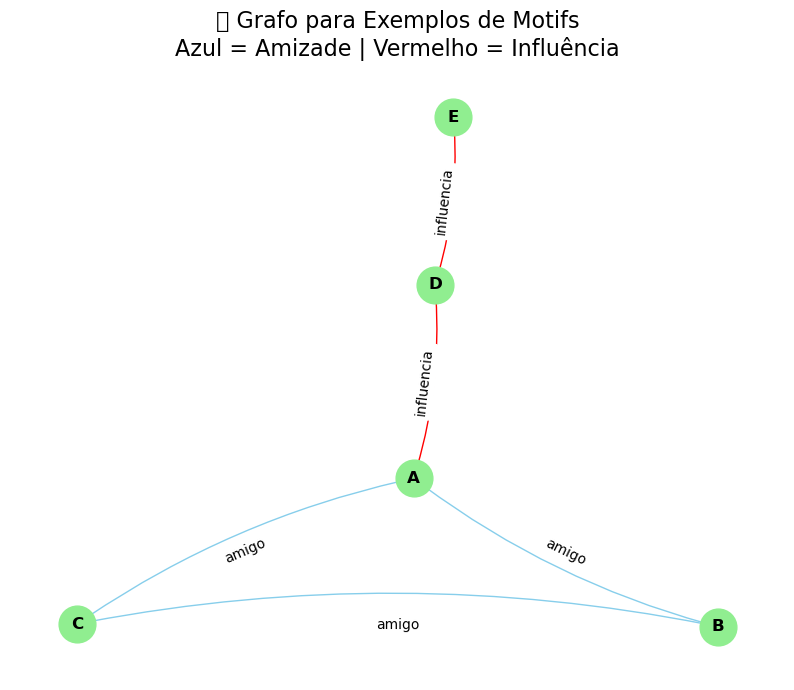

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar o grafo dirigido
G = nx.Graph()

# Adicionar nós
G.add_nodes_from(["A", "B", "C", "D", "E"])

# Adicionar arestas com rótulos (amizade ou influência)
G.add_edge("A", "B", relacao="amigo")
G.add_edge("B", "C", relacao="amigo")
G.add_edge("C", "A", relacao="amigo")
G.add_edge("A", "D", relacao="influencia")
G.add_edge("D", "E", relacao="influencia")

# Definir posições automáticas para os nós
pos = nx.spring_layout(G, seed=42)

# Definir cores para as arestas
edge_colors = []
for u, v, data in G.edges(data=True):
    if data['relacao'] == "amigo":
        edge_colors.append("skyblue")  # azul para amizade
    else:
        edge_colors.append("red")       # vermelho para influência

# Começar o desenho
plt.figure(figsize=(10, 8))

# Desenhar nós
nx.draw_networkx_nodes(G, pos, node_color="lightgreen", node_size=700)

# Desenhar labels dos nós
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

# Desenhar arestas coloridas
nx.draw_networkx_edges(
    G, pos, 
    edge_color=edge_colors, 
    arrows=True, 
    arrowsize=20, 
    connectionstyle='arc3,rad=0.1'  # curva suave nas setas
)

# Labels das arestas (amizade ou influência)
edge_labels = nx.get_edge_attributes(G, "relacao")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Configurações finais do gráfico
plt.title("🔎 Grafo para Exemplos de Motifs\nAzul = Amizade | Vermelho = Influência", fontsize=16)
plt.axis('off')
plt.show()

In [5]:
g = GraphFrame(vertices,edges)

In [6]:
relacionamentos = g.find("(a)-[e]->(b)")
relacionamentos.show()

+-----------+------------------+-----------+
|          a|                 e|          b|
+-----------+------------------+-----------+
|{C, Carlos}|     {C, A, amigo}| {A, Alice}|
| {A, Alice}|     {A, B, amigo}|   {B, Bob}|
|   {B, Bob}|     {B, C, amigo}|{C, Carlos}|
| {A, Alice}|{A, D, influencia}| {D, Diana}|
| {D, Diana}|{D, E, influencia}|   {E, Eva}|
+-----------+------------------+-----------+



In [8]:
relacionamentos_derivados = g.find("(a)-[e1]->(b); (b) - [e2] -> (c)")
relacionamentos_derivados.show()

+-----------+------------------+-----------+------------------+-----------+
|          a|                e1|          b|                e2|          c|
+-----------+------------------+-----------+------------------+-----------+
|   {B, Bob}|     {B, C, amigo}|{C, Carlos}|     {C, A, amigo}| {A, Alice}|
|{C, Carlos}|     {C, A, amigo}| {A, Alice}|     {A, B, amigo}|   {B, Bob}|
| {A, Alice}|     {A, B, amigo}|   {B, Bob}|     {B, C, amigo}|{C, Carlos}|
|{C, Carlos}|     {C, A, amigo}| {A, Alice}|{A, D, influencia}| {D, Diana}|
| {A, Alice}|{A, D, influencia}| {D, Diana}|{D, E, influencia}|   {E, Eva}|
+-----------+------------------+-----------+------------------+-----------+



In [10]:
g.find("(a)-[e1]->(b); (b) - [e2] -> (c); (c) -[e3] -> (a)") \
    .filter("e1.relacao= 'amigo' AND e2.relacao = 'amigo' AND e3.relacao= 'amigo' ") \
    .show()


+-----------+-------------+-----------+-------------+-----------+-------------+
|          a|           e1|          b|           e2|          c|           e3|
+-----------+-------------+-----------+-------------+-----------+-------------+
|   {B, Bob}|{B, C, amigo}|{C, Carlos}|{C, A, amigo}| {A, Alice}|{A, B, amigo}|
|{C, Carlos}|{C, A, amigo}| {A, Alice}|{A, B, amigo}|   {B, Bob}|{B, C, amigo}|
| {A, Alice}|{A, B, amigo}|   {B, Bob}|{B, C, amigo}|{C, Carlos}|{C, A, amigo}|
+-----------+-------------+-----------+-------------+-----------+-------------+



In [12]:
g.find("(a) - [e1] -> (b); (b) -[e2] -> (c) ") \
    .filter("e1.relacao= 'influencia' AND e2.relacao = 'influencia'") \
    .show()

+----------+------------------+----------+------------------+--------+
|         a|                e1|         b|                e2|       c|
+----------+------------------+----------+------------------+--------+
|{A, Alice}|{A, D, influencia}|{D, Diana}|{D, E, influencia}|{E, Eva}|
+----------+------------------+----------+------------------+--------+

